# Attributable Protein Language Model (ESMattribution) with Ridge Regression
This notebook demonstrates training and getting per residue attribution from and ESM2 based model.  Here we use the ESM2 model without modification but use ridge regression to transform those representations into a per-residue prediction.  The demonstration uses RNA binding predictions from RNApred (https://webs.iiitd.edu.in/raghava/rnapred/download.html).  If the sequence id is a uniprot id, the code can download the alphafold prediction and display the per residue RNA binding attribution as a false color.  This code can be run google colab at this link:
http://colab.research.google.com/github/jayunruh/ESMattribution/blob/main/ridge_attribute_rna_binding.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
!pip install py3dmol
import os
if(not os.path.exists('model_utils.py')):
    print('downloading model libraries')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/model_utils.py
if(not os.path.exists('jpdbtools.py')):
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools.py
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools2.py
else:
    print('libraries already downloaded')
#download the training data (upload by hand for customization)
if(not os.path.exists('rna_binding_data.csv')):
    print('downloading training data')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/rna_binding_data.csv

libraries already downloaded


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
import jpdbtools as jutils
#model_utils contains the model definition
import model_utils
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.stats as ss
from sklearn.linear_model import Ridge
import requests

In [2]:
# Set the device (cpu or gpu)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=model_utils.device
print(f"Using device: {device}")

Using device: cuda


In [3]:
#read in our data set
#df=pd.read_csv('yeast_af_ssstats2.csv')
#print('data set average fraction helix',df['f_alpha'].mean())
df=pd.read_csv('rna_binding_data.csv')
df['sequence']=df['sequence'].str.replace('ST3G','')
print('data set number non-binders',(df['label']==False).sum(),'number binders', (df['label']==True).sum())

data set number non-binders 477 number binders 446


In [4]:
esm_model,esmlayer,batch_converter,alphabet=model_utils.loadESMModel(nlayers=33,device=device)

Loading ESM-2 model...


Using cache found in /home/jru/.cache/torch/hub/facebookresearch_esm_main


ESM-2 model loaded.


In [5]:
# Next run the ESM2 model without training to get the per residue representations
reprs=model_utils.getESM2Representations(esm_model,batch_converter,df['sequence'],rep_layer=esmlayer)

  0%|          | 0/923 [00:00<?, ?it/s]

In [6]:
#save the representation matrices
np.savez(f"representation_{esmlayer}_layer_rnabinding.npz",*reprs)

In [7]:
#now calculate the projections of those representations across the sequence
#the projection is the average representation for the protein
repprojs=np.array([reprs[i][0].mean(axis=0) for i in range(len(reprs))])

In [8]:
#save the projections
np.save(f"repr_projections_{esmlayer}_layer_rnabinding.npy",repprojs)

In [9]:
#load the previous projections if they are already calculated
repprojs=np.load("repr_projections_33_layer_rnabinding.npy")

In [10]:
#run the ridge regression across the projections
#higher alpha values constrain the weights to be lower on average
#the model should have the weighted contributions of each layer to the RNA binding
regmodel=Ridge(alpha=0.5).fit(repprojs,df['label'])

In [11]:
#predict all of the protein labels
pred=regmodel.predict(repprojs)

In [12]:
df['ridge_prediction']=pred
df['pred_label']=pred>0.5
ncorr=(df['pred_label']==df['label']).sum()
print('Overall accuracy = ',ncorr/len(df))

Overall accuracy =  0.9848320693391116


In [13]:
df.to_csv('rna_binding_data_ridgepredictions.csv')

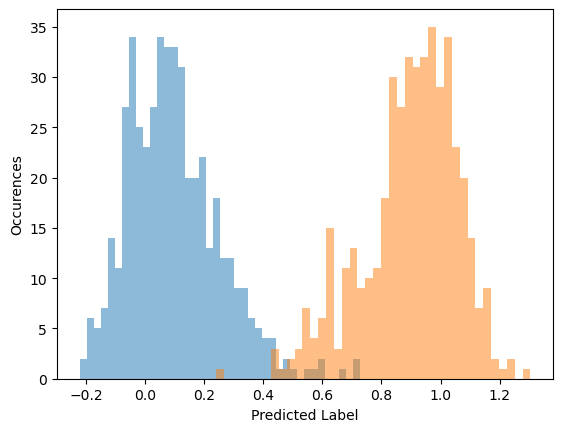

In [14]:
plt.hist(df[df['label']==False]['ridge_prediction'],alpha=0.5,bins=40)
plt.hist(df[df['label']==True]['ridge_prediction'],alpha=0.5,bins=40)
plt.xlabel('Predicted Label')
plt.ylabel('Occurences')
plt.show()

In [15]:
#now predict the sequence specific contributions from the representation matrices
#note that the npz file is a dictionary of arrays
reprfs=np.load('reprs_33_layer_rnabinding.npz')

In [16]:
#for each matrix use the ridge model to predict the contribution of each residue
attrmat=np.full([len(df),2000],np.nan)
pos=0
for name in reprfs:
    #print(name,reprs[name].shape)
    attr=regmodel.predict(reprfs[name][0])
    attrlen=min(len(attr),2000)
    attrmat[pos,:attrlen]=attr[:attrlen]
    pos+=1

In [35]:
np.save('rna_binding_data_ridge_attributions.npy',attrmat)

Text(0, 0.5, 'Test Sequence')

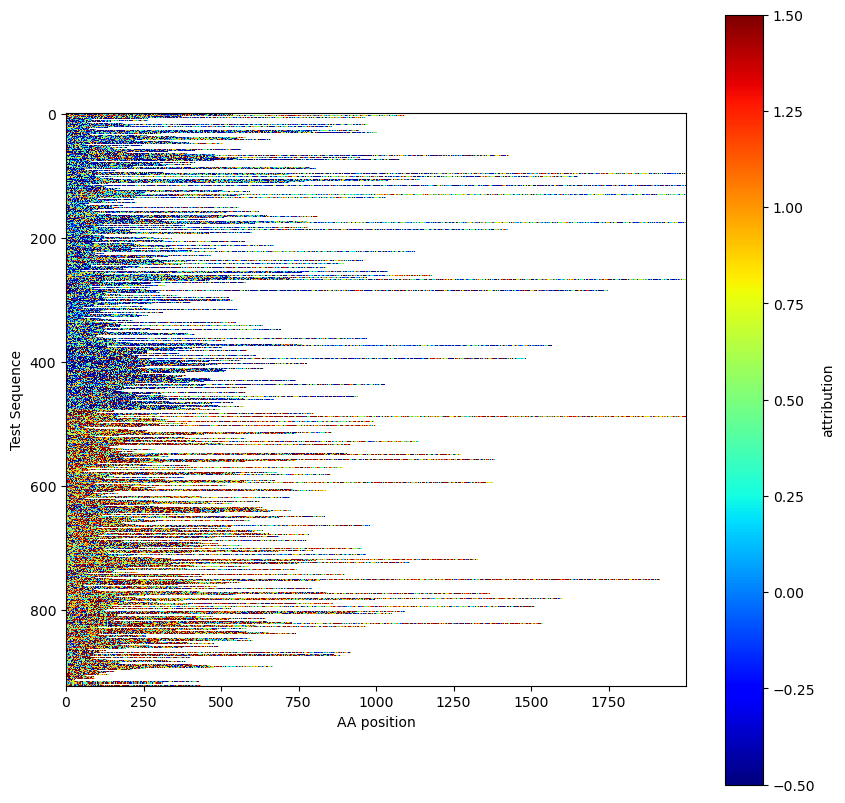

In [17]:
#now plot a heatmap of the attributions
plt.figure(figsize=(10,10))
plt.imshow(attrmat,cmap='jet',vmin=-0.5,vmax=1.5,interpolation='None',aspect=2.0)
plt.colorbar(label='attribution')
plt.xlabel('AA position')
plt.ylabel('Test Sequence')

selected id: sp|Q9Y4C8|RBM19_HUMAN
label: True prediction: 1.0701112


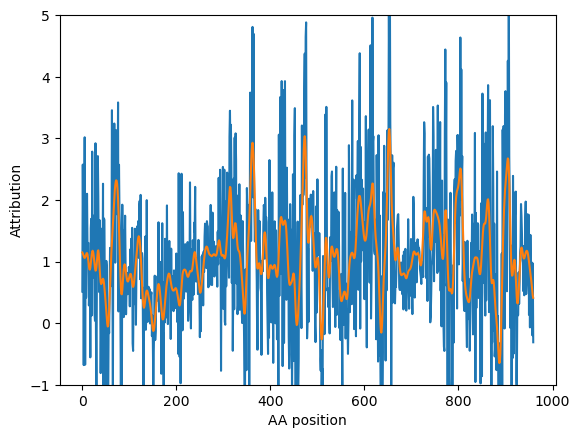

In [42]:
#show the attribution for a selected target
selidx=800
tid=df.loc[selidx,'id']
print('selected id:',tid)
print('label:',df.loc[selidx,'label'],'prediction:',df.loc[selidx,'ridge_prediction'])
seq=df.loc[selidx,'sequence']
seqlen=min(len(seq),2000)
attr=attrmat[selidx,:seqlen]
smattr=ndi.gaussian_filter(attr,sigma=3)
plt.plot(attr)
plt.plot(smattr)
plt.ylim(-1,5)
plt.xlabel('AA position')
plt.ylabel('Attribution')
plt.show()

In [43]:
#finally load the alphafold structure
selid=tid.split('|')[1]
print('getting af2 prediction for id',selid)
url='https://alphafold.ebi.ac.uk/files/AF-'+selid+'-F1-model_v4.pdb'
pdbstr=requests.get(url).text

getting af2 prediction for id Q9Y4C8


In [44]:
pdbdf=jutils.cleanpdbdf(jutils.jpt2.getpdbdffromstr(pdbstr))
pdbdf.head()

,type,atom,atype,resname,chain,residue,x,y,z,unk,temp,element
0,ATOM,1,N,MET,A,1,-20.164000,29.773001,-52.566002,1.0,60.060001,N
1,ATOM,2,CA,MET,A,1,-20.260000,28.389000,-52.049000,1.0,60.060001,C
2,ATOM,3,C,MET,A,1,-20.514999,28.457001,-50.561001,1.0,60.060001,C
3,ATOM,4,CB,MET,A,1,-18.985001,27.566000,-52.275002,1.0,60.060001,C
4,ATOM,5,O,MET,A,1,-19.749001,29.093000,-49.847000,1.0,60.060001,O


In [45]:
#map the smoothed attribution to the residues
resmap={i+1:smattr[i] for i in range(len(smattr))}
pdbdf['temp']=pdbdf['residue'].map(resmap)
#write the mapped pdb if desired
_=jutils.writepdbdf(pdbdf,selid+'_ridge_mapped.pdb')

In [46]:
view=jutils.py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',width=600,height=600)
view.addModel(jutils.writepdbdf(pdbdf),'pdb')
#view.addModel(pdbstr,'pdb') #to view the raw AF data
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1.5}}})
#view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.